<a href="https://colab.research.google.com/github/grace3999/wireless_fiber_photometry/blob/master/Carlson_FP_tethered.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [193]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [194]:
#getting and working with data
import pandas as pd
import numpy as np
import re
import os
import datetime as dt
import string
from numpy import trapz
from scipy import signal

#visualizing results
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('poster', rc={'font.size':35,
                              'axes.titlesize':50,
                              'axes.labelsize':35})

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 15000)
pd.set_option('display.max_colwidth', -1)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

### Prep meta data

In [195]:
meta_path = '/content/drive/Shareddrives/Schindler Iterative Translation Lab/data/Carlson_Lab/data/Carlson_FP_meta.xlsx'

data_meta = pd.read_excel(meta_path)

data_meta = pd.DataFrame(data = data_meta)
print(data_meta.shape)

data_meta.head()

(15, 3)


animal    sensor  cohort
0  1283.0  dopamine  4.0   
1  1338.0  dopamine  4.0   
2  1341.0  dopamine  4.0   
3  1343.0  dopamine  4.0   
4  1344.0  dopamine  4.0

### Prep behavioral data

#### Get paths - separate folders for each day/animal

In [196]:
outer_path = '/content/drive/Shareddrives/Schindler Iterative Translation Lab/data/Carlson_Lab/data/DA'

outer_file_list = os.listdir(outer_path)

outer_path_list = []

for name in outer_file_list:
    int_path = outer_path + '/' + name
    outer_path_list.append(int_path)

print(len(outer_path_list))
outer_path_list[0]

78


'/content/drive/Shareddrives/Schindler Iterative Translation Lab/data/Carlson_Lab/data/DA/1420-220701-091153'

In [197]:
#only need the 'TRANS_Z-scoreData' files
inner_path_list = []

for outer_path in outer_path_list:

    inner_file_list = os.listdir(outer_path)
    for inner_file in inner_file_list:
        if inner_file.startswith('TRANS_Z-scoreData'):
            int_path = outer_path + '/' + inner_file
            inner_path_list.append(int_path)
            
print(len(inner_path_list))
inner_path_list

557


['/content/drive/Shareddrives/Schindler Iterative Translation Lab/data/Carlson_Lab/data/DA/1420-220701-091153/TRANS_Z-scoreData_BOX2_Bit#7.txt',
 '/content/drive/Shareddrives/Schindler Iterative Translation Lab/data/Carlson_Lab/data/DA/1420-220701-091153/TRANS_Z-scoreData_BOX2_Bit#6.txt',
 '/content/drive/Shareddrives/Schindler Iterative Translation Lab/data/Carlson_Lab/data/DA/1420-220701-091153/TRANS_Z-scoreData_BOX2_Bit#5.txt',
 '/content/drive/Shareddrives/Schindler Iterative Translation Lab/data/Carlson_Lab/data/DA/1420-220701-091153/TRANS_Z-scoreData_BOX2_Bit#4.txt',
 '/content/drive/Shareddrives/Schindler Iterative Translation Lab/data/Carlson_Lab/data/DA/1420-220701-091153/TRANS_Z-scoreData_BOX2_Bit#3.txt',
 '/content/drive/Shareddrives/Schindler Iterative Translation Lab/data/Carlson_Lab/data/DA/1420-220701-091153/TRANS_Z-scoreData_BOX2_Bit#2.txt',
 '/content/drive/Shareddrives/Schindler Iterative Translation Lab/data/Carlson_Lab/data/DA/1420-220701-091153/TRANS_Z-scoreData_BO

In [208]:
data = pd.DataFrame()
i=0
for path in inner_path_list:
    print(path)
    print(i)
    i+=1
    
    data_int = pd.read_table(path).reset_index().dropna(axis=1)
    data_int = pd.DataFrame(data = data_int)
    data_int_mean = pd.DataFrame(data=data_int.mean(axis=1), columns=['signal']).reset_index()
    data_int_mean['file_name'] = path.split('/')[-2]
    data_int_mean['task'] = path.split('/')[-3]
    data_int_mean['bit'] = path.split('/')[-1].split('_')[-1].split('.')[0][-1]
    data_int_mean['trial_count'] = data_int.shape[1]
    data_int_mean['animal'] = path.split('/')[-2].split('-')[0]
    data_int_mean['date'] = path.split('/')[-2].split('-')[1]
    
    print(data_int_mean.shape)
    
    if data.shape[0] == 0:
        data = data_int_mean
    else:
        data = pd.concat([data, data_int_mean], axis=0) 
        
    print(data.shape)
        
print(data.shape)
data.head()

/content/drive/Shareddrives/Schindler Iterative Translation Lab/data/Carlson_Lab/data/DA/1420-220701-091153/TRANS_Z-scoreData_BOX2_Bit#7.txt
0
(3052, 8)
(3052, 8)
/content/drive/Shareddrives/Schindler Iterative Translation Lab/data/Carlson_Lab/data/DA/1420-220701-091153/TRANS_Z-scoreData_BOX2_Bit#6.txt
1
(3052, 8)
(6104, 8)
/content/drive/Shareddrives/Schindler Iterative Translation Lab/data/Carlson_Lab/data/DA/1420-220701-091153/TRANS_Z-scoreData_BOX2_Bit#5.txt
2
(3052, 8)
(9156, 8)
/content/drive/Shareddrives/Schindler Iterative Translation Lab/data/Carlson_Lab/data/DA/1420-220701-091153/TRANS_Z-scoreData_BOX2_Bit#4.txt
3
(3052, 8)
(12208, 8)
/content/drive/Shareddrives/Schindler Iterative Translation Lab/data/Carlson_Lab/data/DA/1420-220701-091153/TRANS_Z-scoreData_BOX2_Bit#3.txt
4
(3052, 8)
(15260, 8)
/content/drive/Shareddrives/Schindler Iterative Translation Lab/data/Carlson_Lab/data/DA/1420-220701-091153/TRANS_Z-scoreData_BOX2_Bit#2.txt
5
(3052, 8)
(18312, 8)
/content/drive/Shar

index    signal           file_name task bit  trial_count animal    date
0  0      0.227158  1420-220701-091153  DA   7   33           1420   220701
1  1      0.168079  1420-220701-091153  DA   7   33           1420   220701
2  2      0.103274  1420-220701-091153  DA   7   33           1420   220701
3  3      0.037545  1420-220701-091153  DA   7   33           1420   220701
4  4     -0.023050  1420-220701-091153  DA   7   33           1420   220701

#### Map bits

In [209]:
bit_FR1 ={'0':'lever_out',
          '1':'head_entry',
          '2':'reward',
          '3':'lever_press',
          '4':'lever_press',
          '5':'reward_HE',
          '6':'correct_alt',
          '7':'incorrect_alt'}

bit_map ={'0':'first_le',
          '1':'second_le',
          '2':'reward',
          '3':'first_press',
          '4':'first_press',
          '5':'reward_HE',
          '6':'correct_alt',
          '7':'incorrect_alt'}

data['bit_str'] = data['bit'].map(bit_map)
data.head(1)

index    signal           file_name task bit  trial_count animal    date        bit_str
0  0      0.227158  1420-220701-091153  DA   7   33           1420   220701  incorrect_alt

#### Combine with meta

In [210]:
data['animal'] = data['animal'].astype(int)
data = data.merge(data_meta, on=['animal'])
print(data.shape)

data.head()

(1699964, 11)


index    signal           file_name task bit  trial_count  animal    date        bit_str    sensor  cohort
0  0      0.227158  1420-220701-091153  DA   7   33           1420    220701  incorrect_alt  dopamine  5.0   
1  1      0.168079  1420-220701-091153  DA   7   33           1420    220701  incorrect_alt  dopamine  5.0   
2  2      0.103274  1420-220701-091153  DA   7   33           1420    220701  incorrect_alt  dopamine  5.0   
3  3      0.037545  1420-220701-091153  DA   7   33           1420    220701  incorrect_alt  dopamine  5.0   
4  4     -0.023050  1420-220701-091153  DA   7   33           1420    220701  incorrect_alt  dopamine  5.0

#### Map session

In [243]:
data_final = pd.DataFrame()

for cohort in data['cohort'].unique():
  print(cohort)
  data_int = data[data['cohort']==cohort]
  date_map = dict(zip(data_int['date'].sort_values().unique(), np.arange(1,len(data_int['date'].unique())+1)))
  data_int['session'] = data_int['date'].map(date_map)

  if data_final.shape[0] == 0:
      data_final = data_int
  else:
      data_final = pd.concat([data_final, data_int], axis=0) 
        
  print(data_final.shape)
        

data_final['index_round'] = (data_final['index'] / 100).round(1) 

print(data_final.shape)
data_final.head()

5.0
(289940, 12)
4.0
(1022420, 12)
6.0
(1699964, 12)
(1699964, 13)


index    signal           file_name task bit  trial_count  animal    date        bit_str    sensor  cohort  session  index_round
0  0      0.227158  1420-220701-091153  DA   7   33           1420    220701  incorrect_alt  dopamine  5.0     5        0.0        
1  1      0.168079  1420-220701-091153  DA   7   33           1420    220701  incorrect_alt  dopamine  5.0     5        0.0        
2  2      0.103274  1420-220701-091153  DA   7   33           1420    220701  incorrect_alt  dopamine  5.0     5        0.0        
3  3      0.037545  1420-220701-091153  DA   7   33           1420    220701  incorrect_alt  dopamine  5.0     5        0.0        
4  4     -0.023050  1420-220701-091153  DA   7   33           1420    220701  incorrect_alt  dopamine  5.0     5        0.0

### Analysis

#### AUC

In [245]:
start_time = 1000
end_time = 1500

data_AUC_pos = data_final[(data_final['index']>=start_time) & (data_final['index']<end_time) & (data_final['signal']>0)]
data_AUC_neg = data_final[(data_final['index']>=start_time) & (data_final['index']<end_time) & (data_final['signal']<0)]

data_AUC_gb = data_AUC_pos.groupby(['sensor', 'session', 'animal', 'bit_str'])['signal'].apply(lambda x: np.trapz(x)).reset_index(name='AUC_pos')
data_AUC_gb['AUC_neg'] = data_AUC_neg.groupby(['sensor', 'session', 'animal', 'bit_str'])['signal'].apply(lambda x: np.trapz(x)).reset_index(name='AUC_neg')['AUC_neg']

data_AUC_gb.head()

sensor  session  animal        bit_str     AUC_pos    AUC_neg
0  dopamine  1        1283    correct_alt    49.376534  -16.956511
1  dopamine  1        1283    first_le       9.365860   -24.345907
2  dopamine  1        1283    first_press    122.905909 -37.509326
3  dopamine  1        1283    incorrect_alt  46.521441  -13.192383
4  dopamine  1        1283    reward         49.376534  -16.956511

#### max signal

In [246]:
start_time = 1000
end_time = 1500

data_PA = data_final[(data_final['index']>=start_time) & (data_final['index']<end_time)]

data_PA_gb = data_PA.groupby(['sensor', 'session', 'animal', 'bit_str'])['signal'].max().reset_index(name='peak_max')
data_PA_gb['peak_min'] = data_PA.groupby(['sensor', 'session', 'animal', 'bit_str'])['signal'].min().reset_index(name='peak_min')['peak_min']


data_PA_gb.head()

sensor  session  animal        bit_str  peak_max  peak_min
0  dopamine  1        1283    correct_alt    0.426914 -0.286289
1  dopamine  1        1283    first_le       0.184676 -0.258846
2  dopamine  1        1283    first_press    0.570828 -0.332231
3  dopamine  1        1283    incorrect_alt  0.522460 -0.228830
4  dopamine  1        1283    reward         0.426914 -0.286289

In [247]:
data_analysis = data_PA_gb.merge(data_AUC_gb, on=['sensor', 'session', 'animal', 'bit_str'])

data_analysis.head()

sensor  session  animal        bit_str  peak_max  peak_min     AUC_pos    AUC_neg
0  dopamine  1        1283    correct_alt    0.426914 -0.286289  49.376534  -16.956511
1  dopamine  1        1283    first_le       0.184676 -0.258846  9.365860   -24.345907
2  dopamine  1        1283    first_press    0.570828 -0.332231  122.905909 -37.509326
3  dopamine  1        1283    incorrect_alt  0.522460 -0.228830  46.521441  -13.192383
4  dopamine  1        1283    reward         0.426914 -0.286289  49.376534  -16.956511

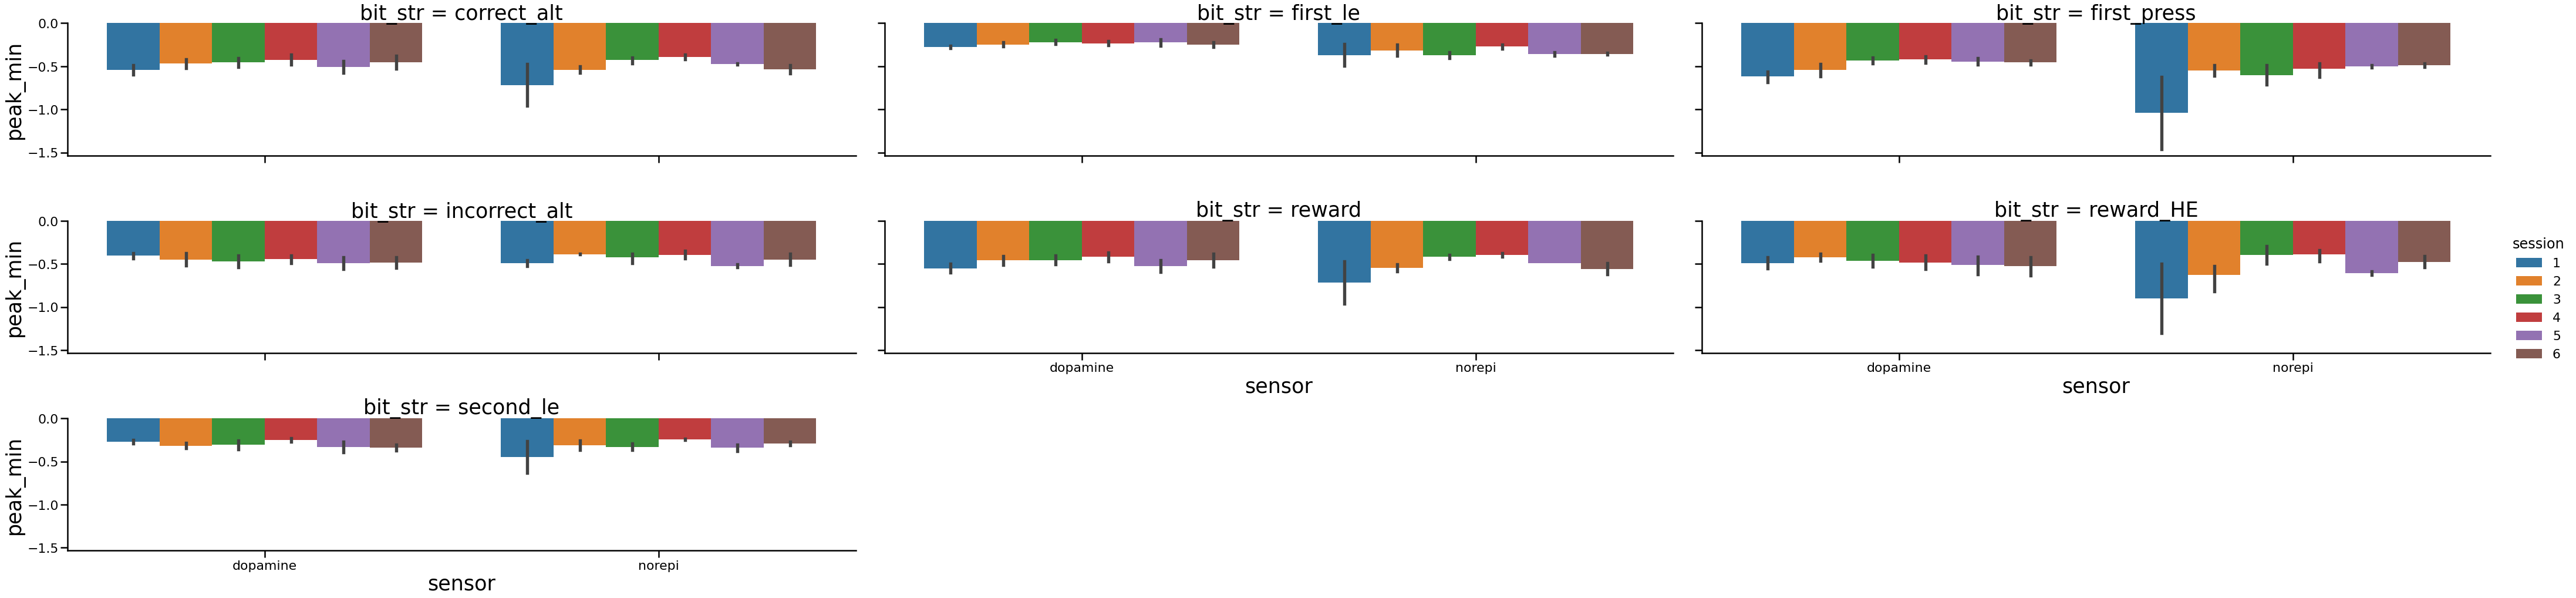

In [249]:
sns.catplot(x='sensor', y='peak_min', data=data_analysis, ci=68, kind='bar', hue='session', height=5, aspect=4, col='bit_str', col_wrap=3)
plt.show()

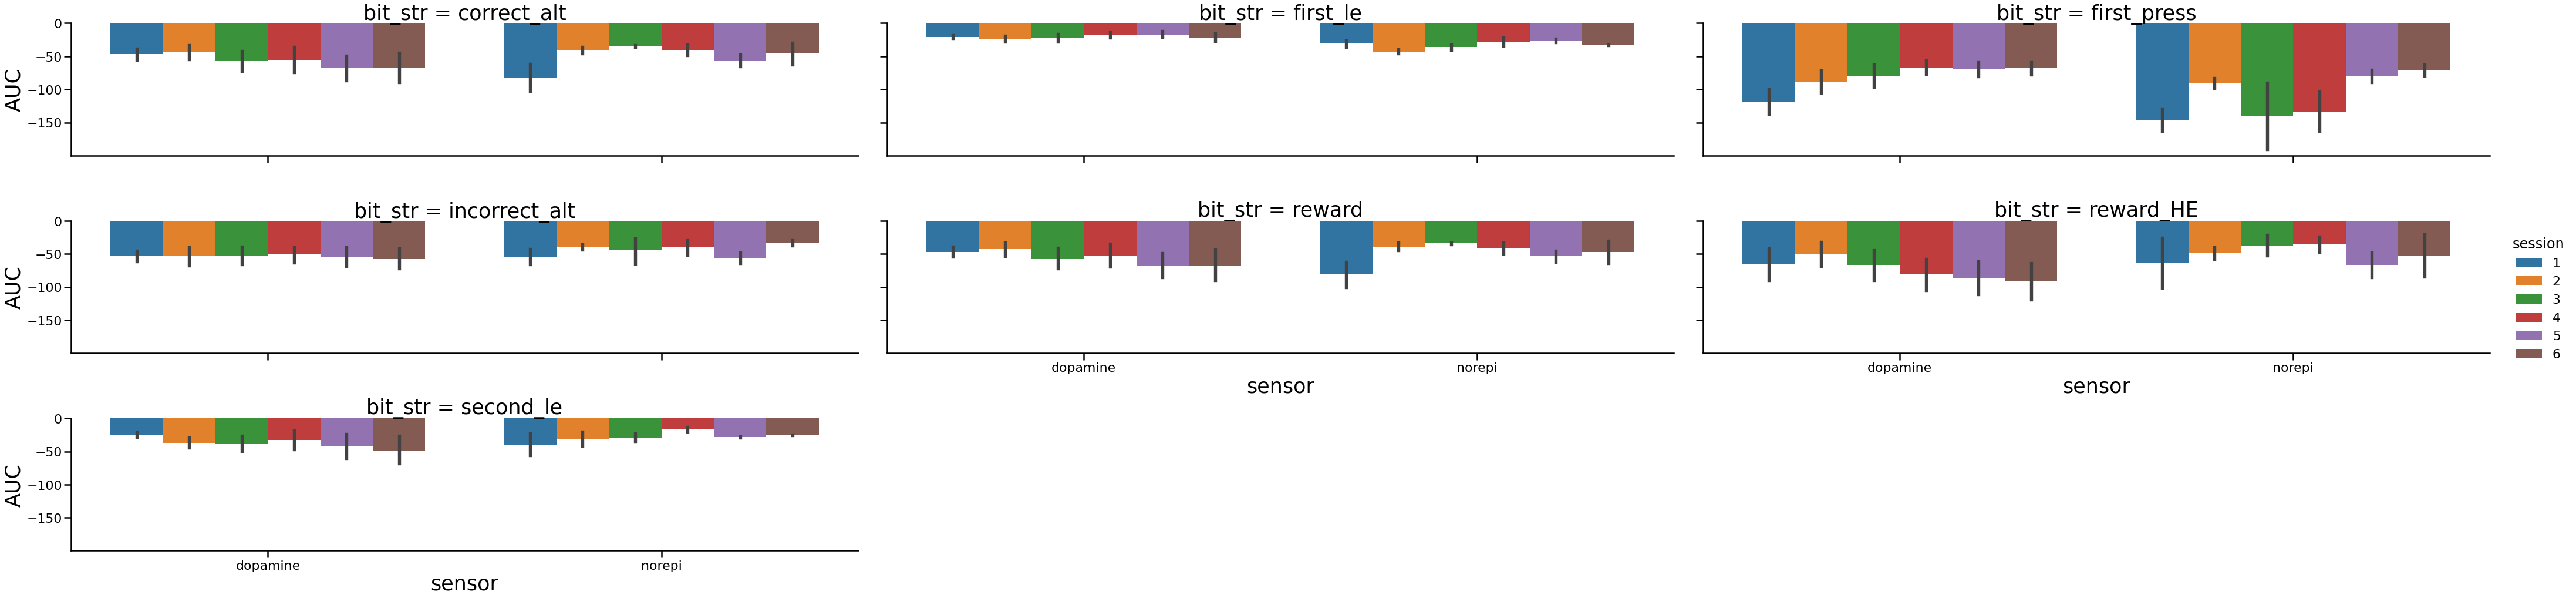

In [241]:
sns.catplot(x='sensor', y='AUC', data=data_analysis, ci=68, kind='bar', hue='session', height=5, aspect=4, col='bit_str', col_wrap=3)
plt.show()

#### Viz

In [213]:
data_final.groupby(['session', 'animal'])['bit_str'].value_counts()

session  animal  bit_str      
1        1283    first_press      6104
                 correct_alt      3052
                 first_le         3052
                 incorrect_alt    3052
                 reward           3052
                 reward_HE        3052
                 second_le        3052
         1338    first_press      6104
                 correct_alt      3052
                 first_le         3052
                 incorrect_alt    3052
                 reward           3052
                 reward_HE        3052
                 second_le        3052
         1341    first_press      6104
                 correct_alt      3052
                 first_le         3052
                 incorrect_alt    3052
                 reward           3052
                 reward_HE        3052
                 second_le        3052
         1343    first_press      6104
                 correct_alt      3052
                 first_le         3052
                 incorrect_alt   

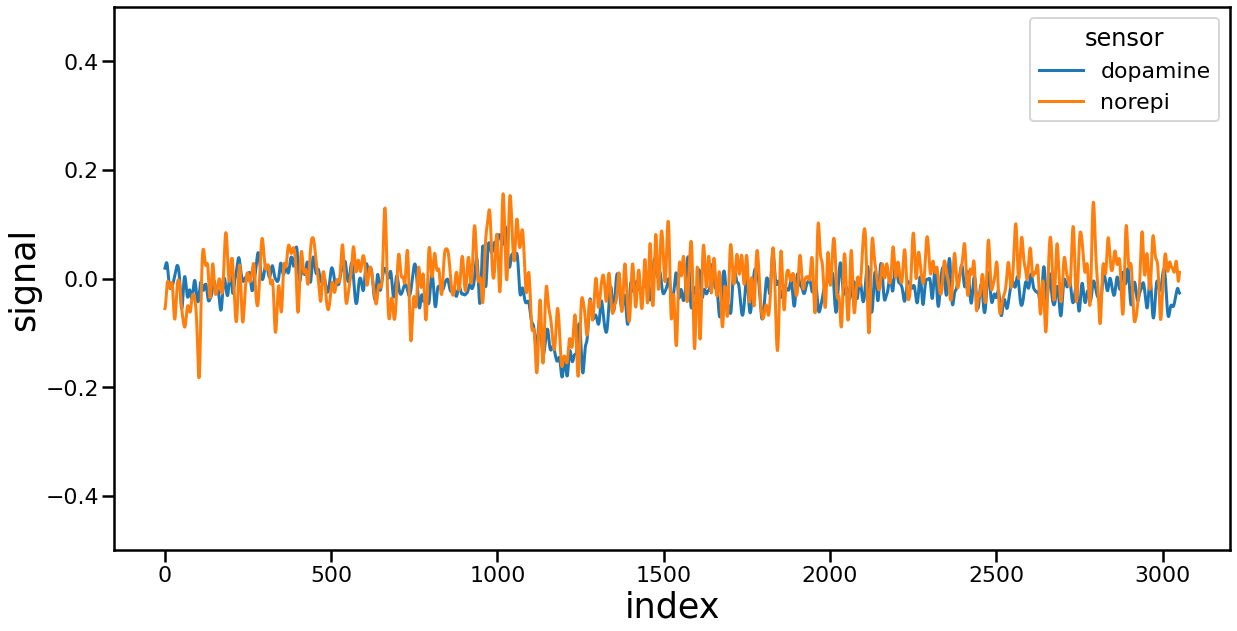

In [216]:
d=data_final[data_final['bit_str']=='incorrect_alt']
#d=d[d['session']==6]

plt.figure(figsize=(20,10))
ax=sns.lineplot(x='index', y='signal', data=d, ci=None, hue='sensor')

ax.set(ylim=(-.5,.5))

plt.show()

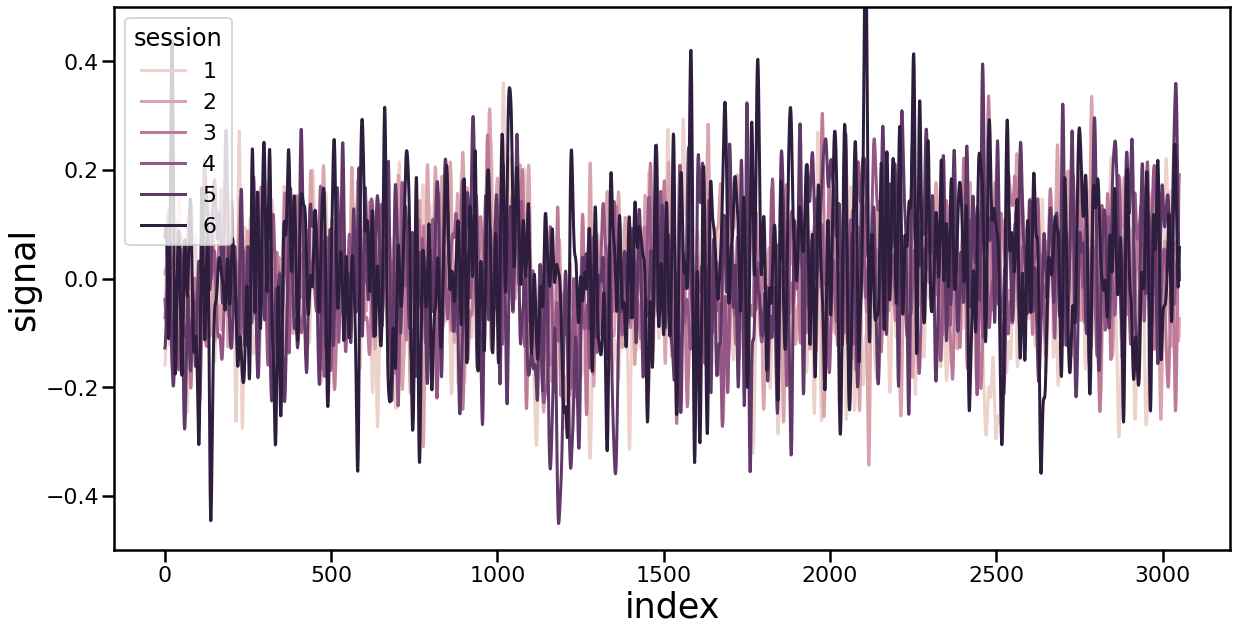

In [ ]:
d=data_final[data_final['sesnor']=='norepi']
d=d[d['bit_str']=='incorrect_alt']

plt.figure(figsize=(20,10))
ax=sns.lineplot(x='index', y='signal', data=d, ci=None, hue='session')

ax.set(ylim=(-.5,.5))

plt.show()

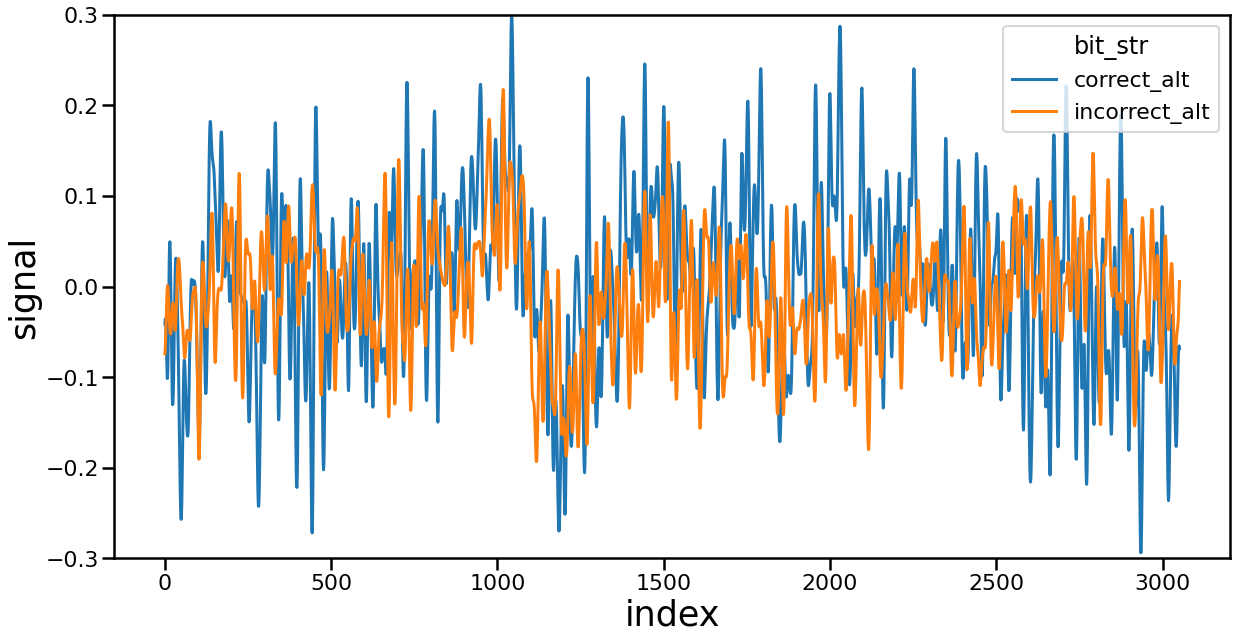

In [ ]:
d=data_final[data_final['sesnor']=='norepi']
d=d[d['session']<4]

bit_list = ['correct_alt', 'incorrect_alt']
d=d[d['bit_str'].isin(bit_list)]

d=d.groupby(['animal', 'index', 'bit_str'])['signal'].mean().reset_index()

plt.figure(figsize=(20,10))
ax=sns.lineplot(x='index', y='signal', data=d, ci=None, hue='bit_str')

ax.set(ylim=(-.3,.3))

plt.show()

1420


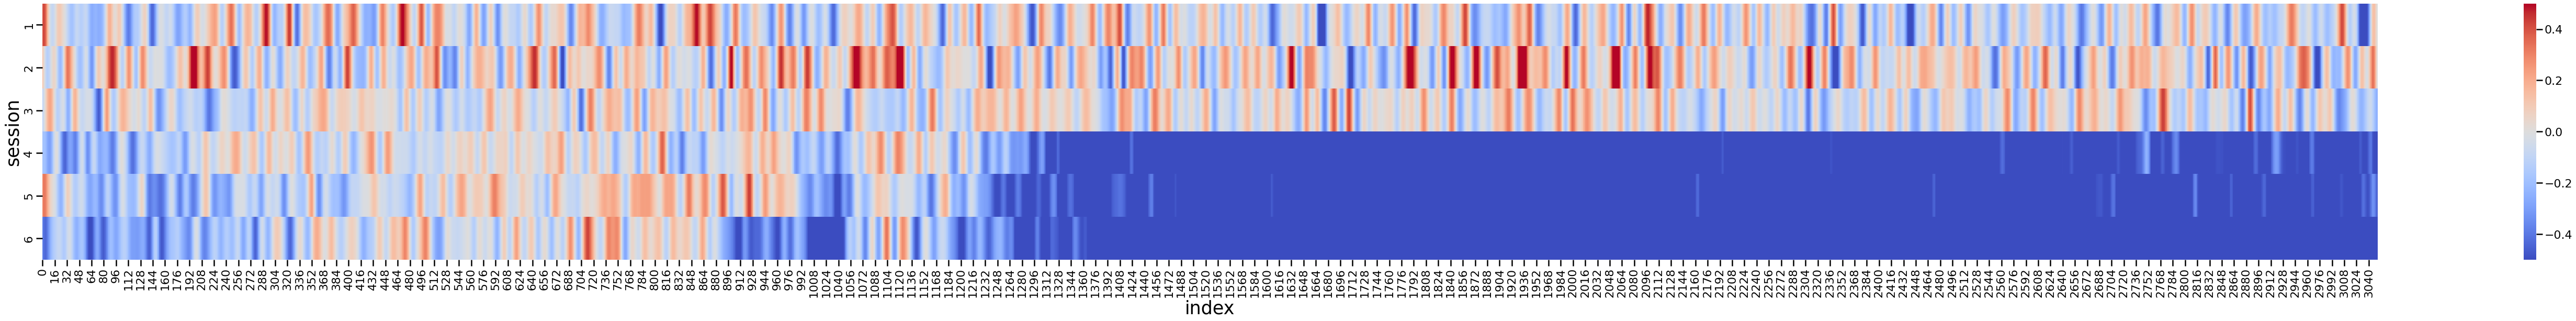

1421


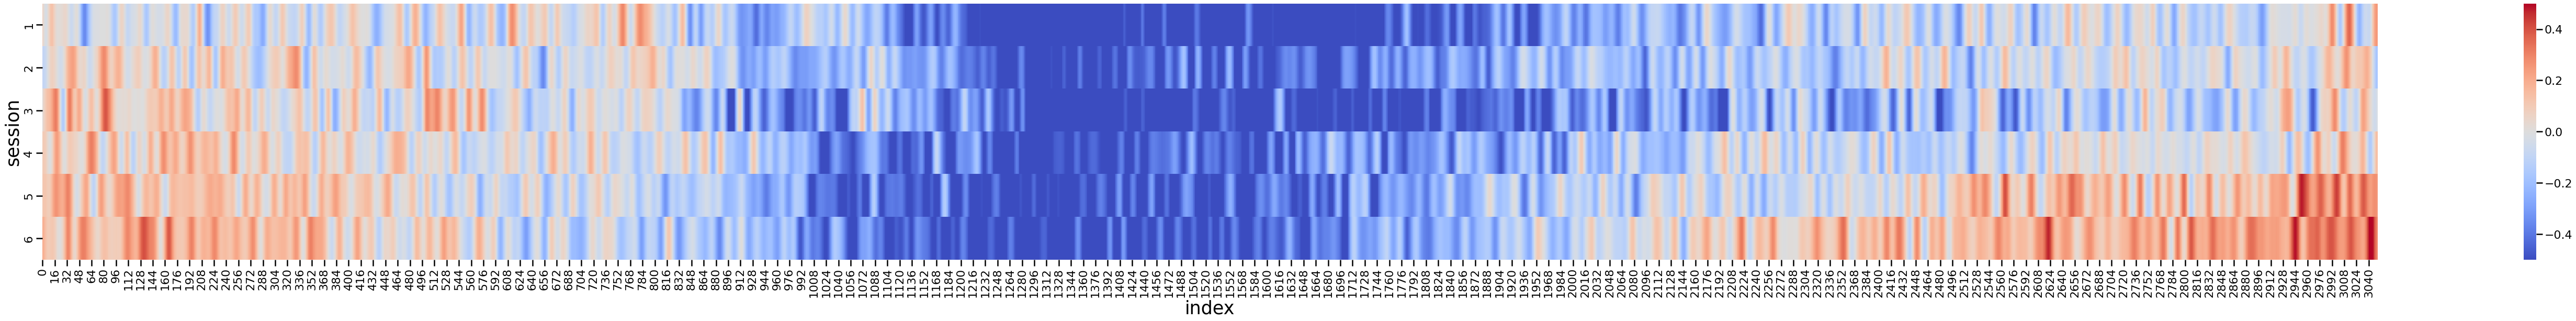

1344


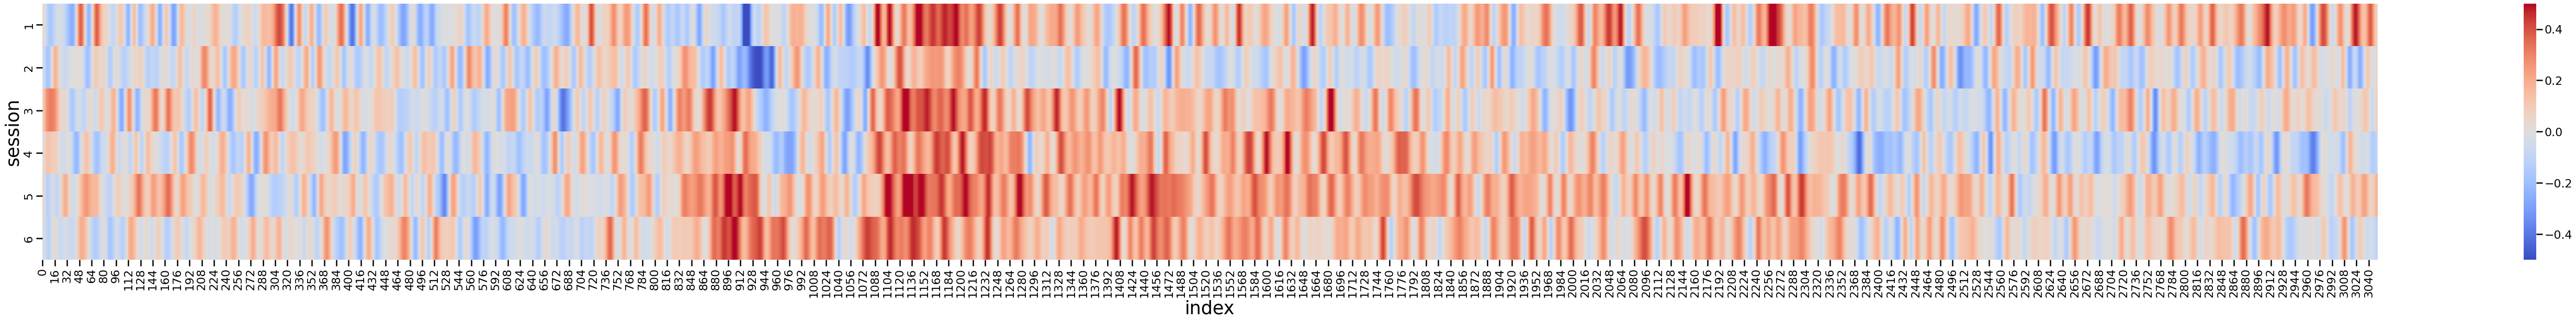

1343


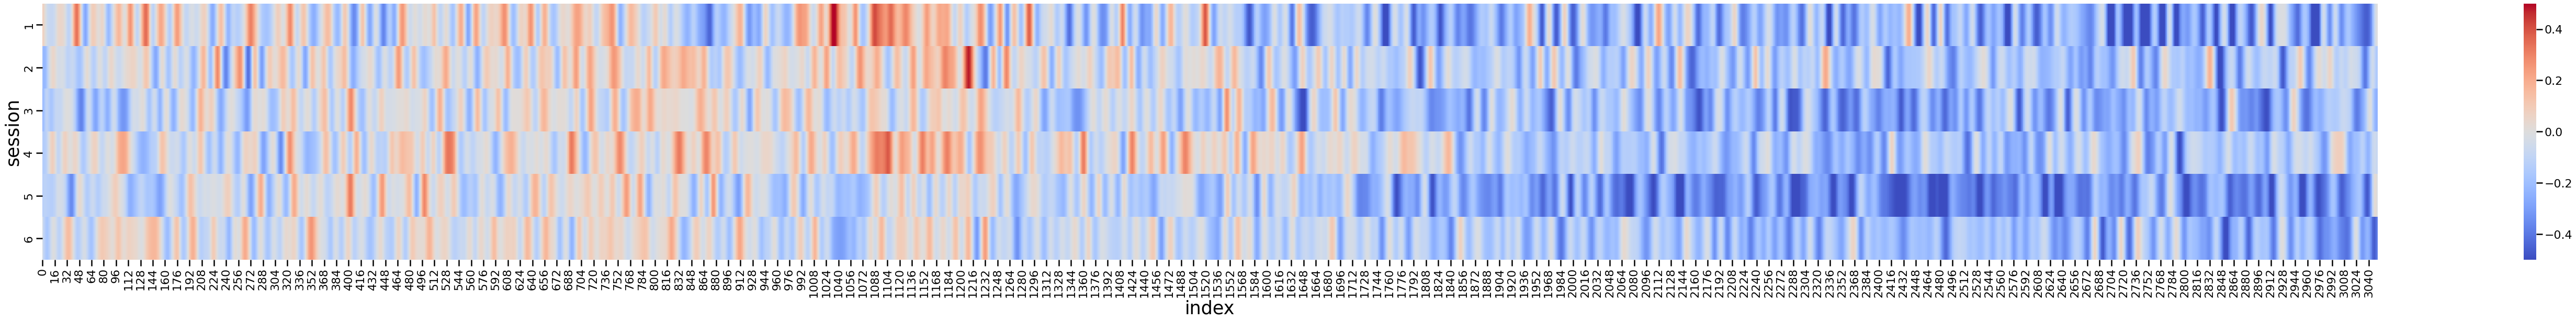

1283


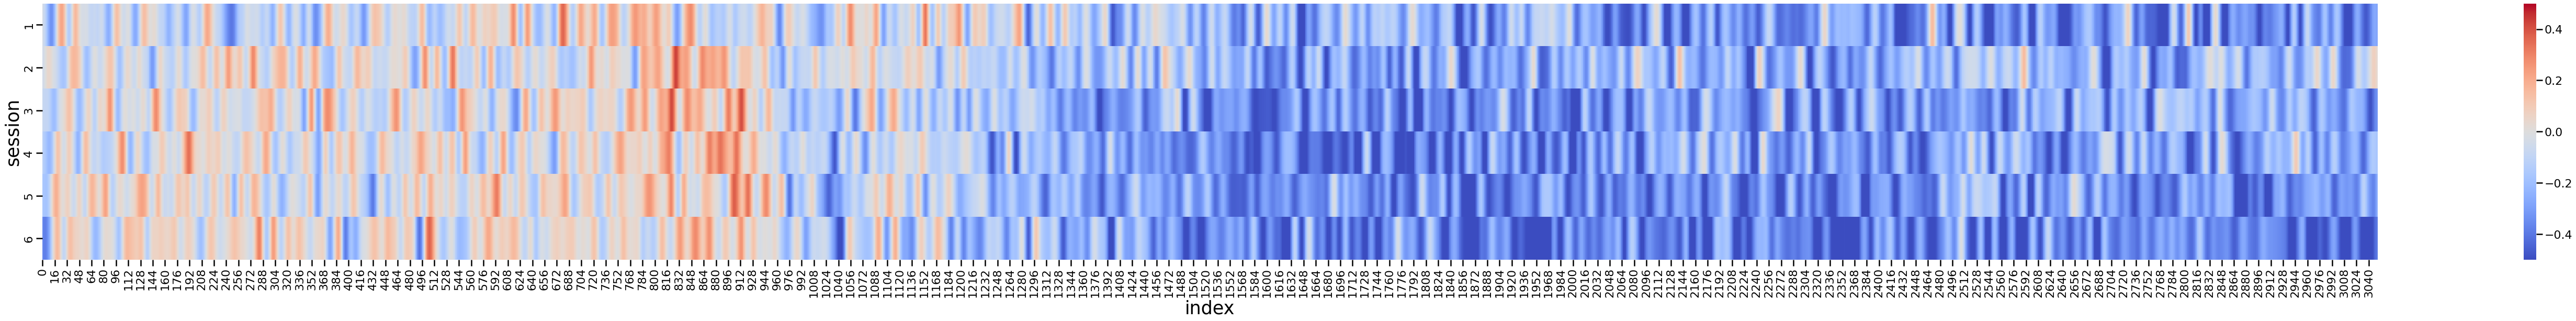

1338


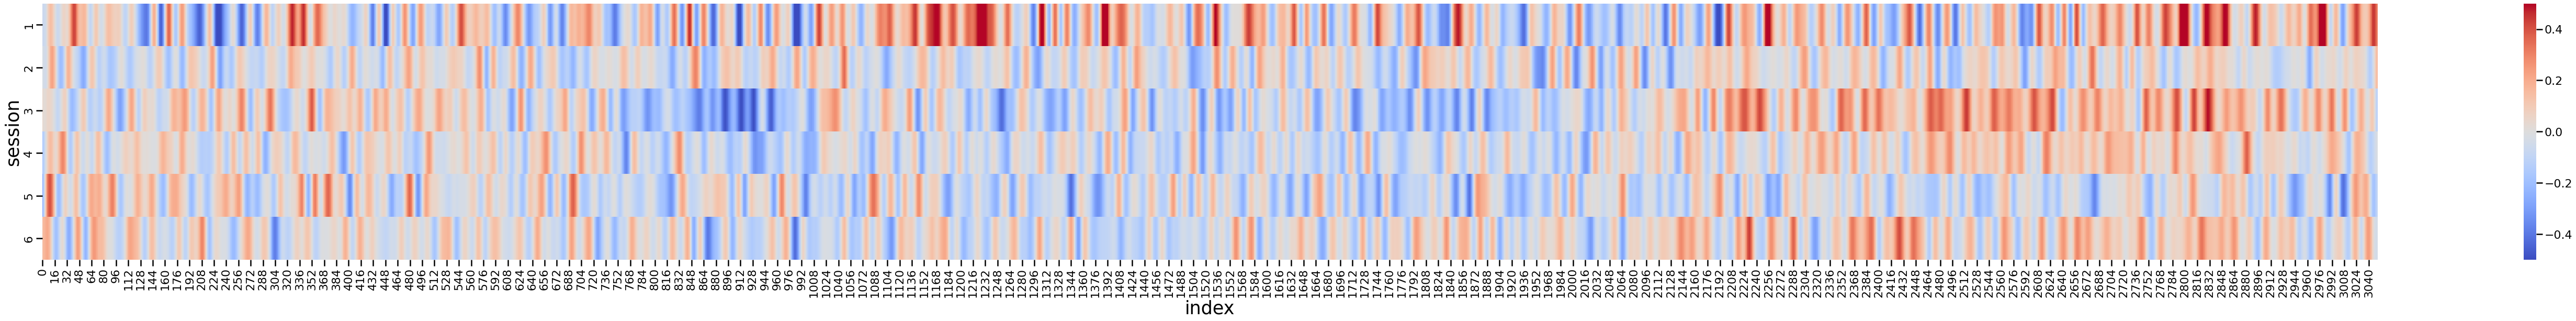

1341


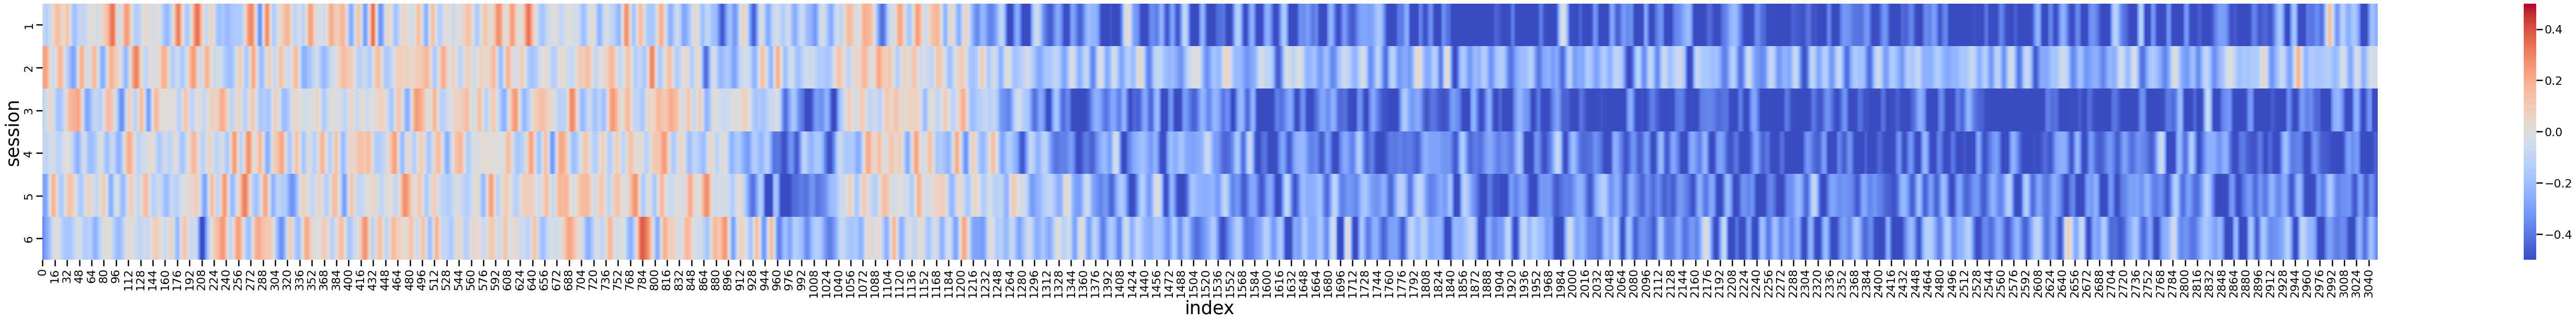

1687


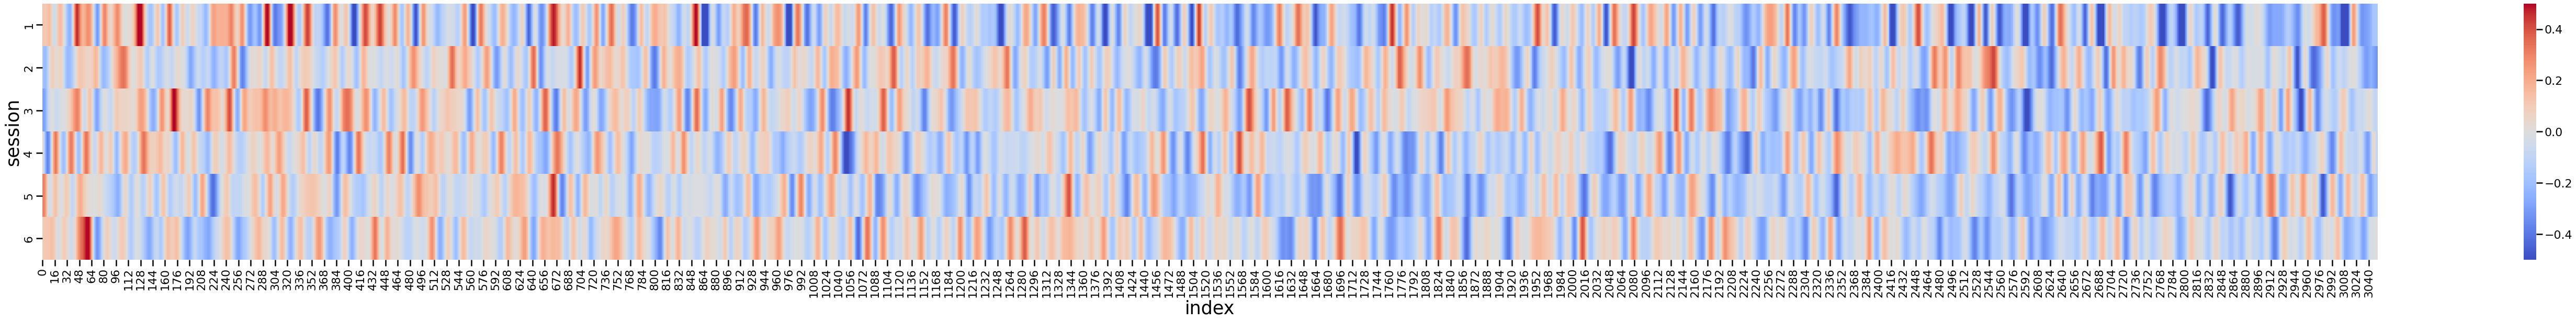

1686


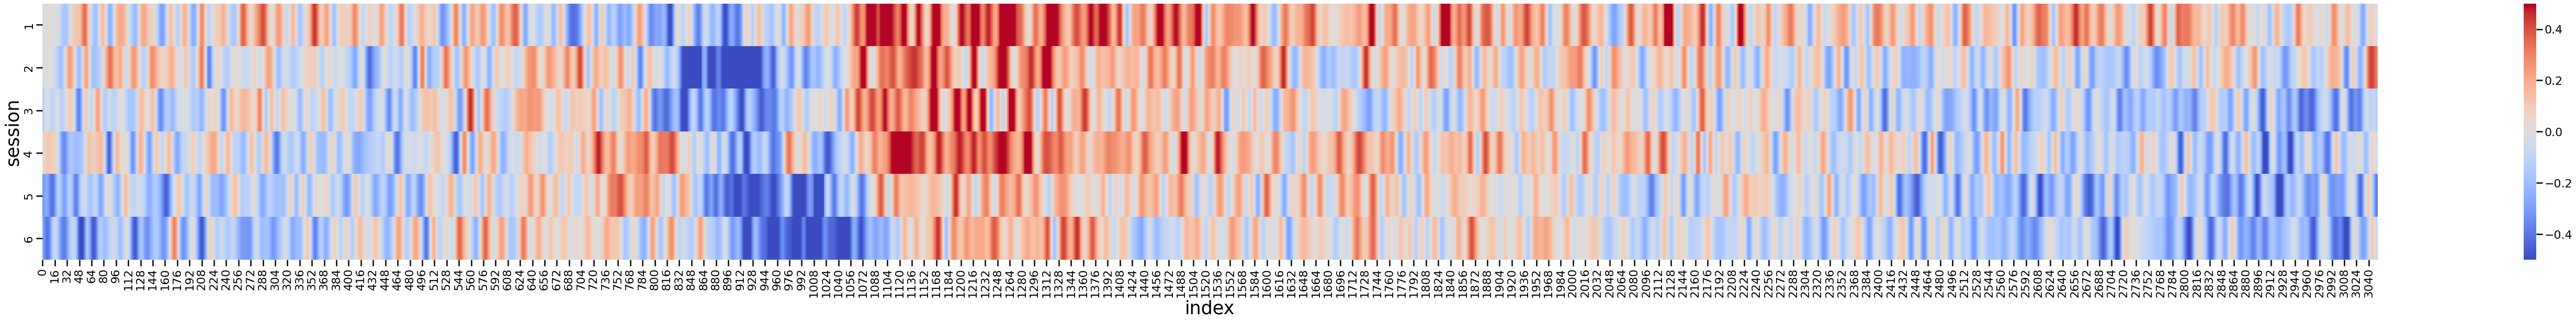

In [ ]:
d=data_final[data_final['sesnor']=='dopamine']
d=d[d['bit_str']=='reward_HE']

for animal in d['animal'].unique():
  print(animal)

  data_int = d[d['animal']==animal]

  groupby = data_int.pivot('session', 'index', "signal")
  plt.figure(figsize=(100,9))
  ax = sns.heatmap(groupby, cmap="coolwarm", vmin=-.5, vmax=.5)
  plt.show()

1420


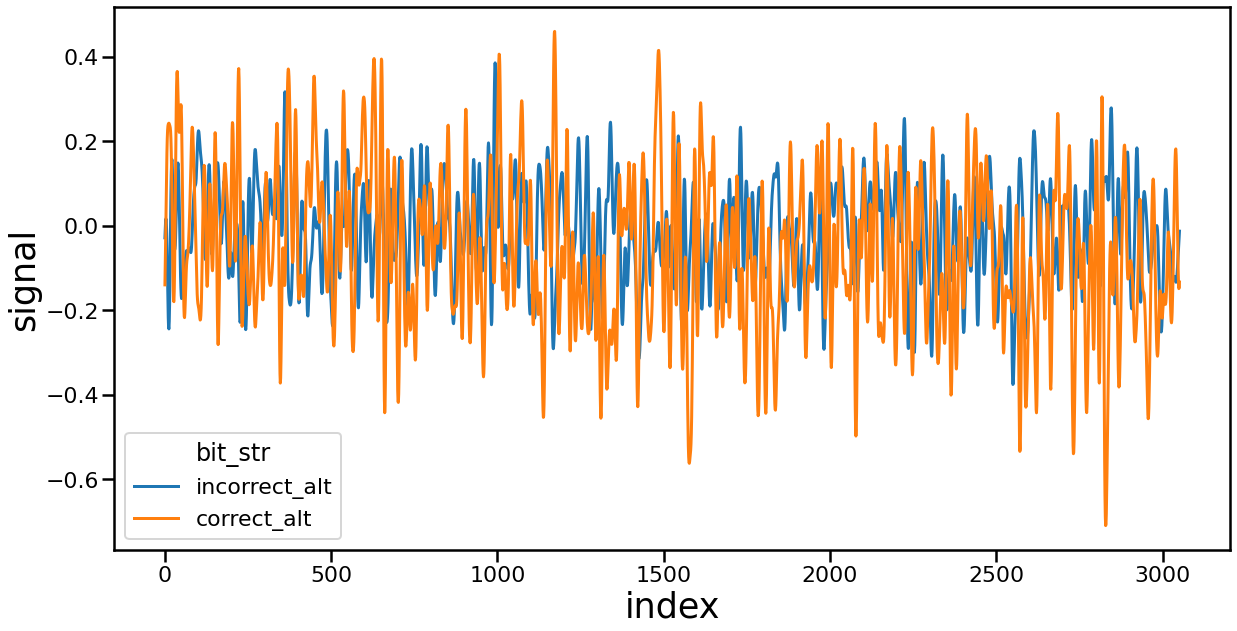

1421


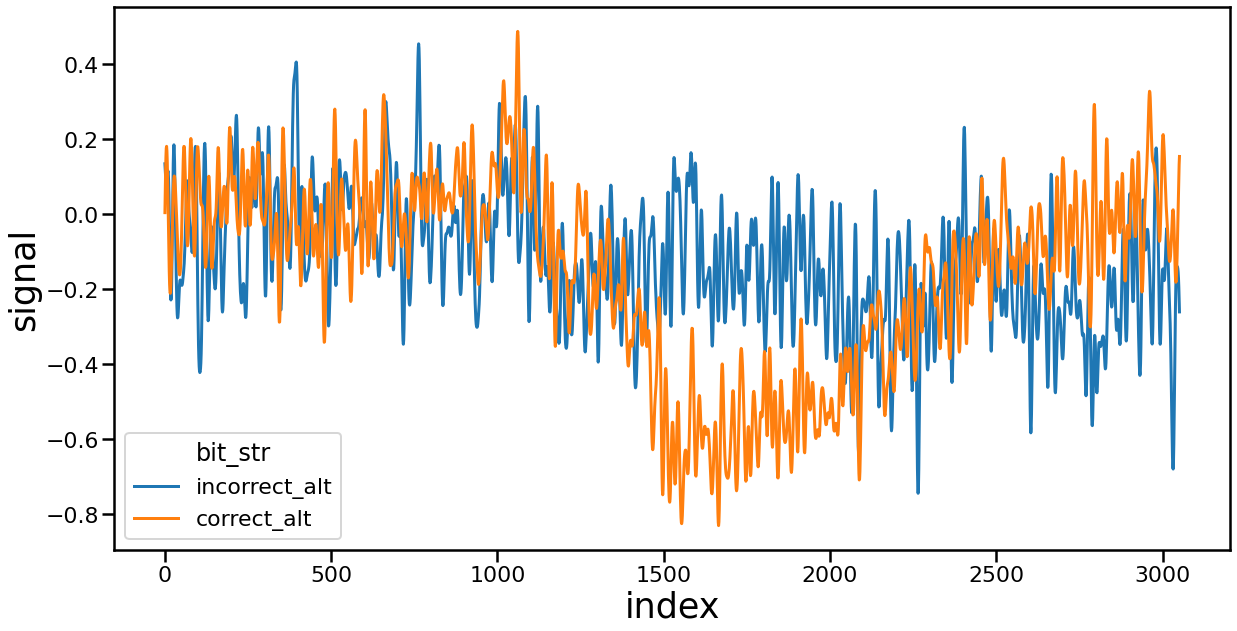

1344


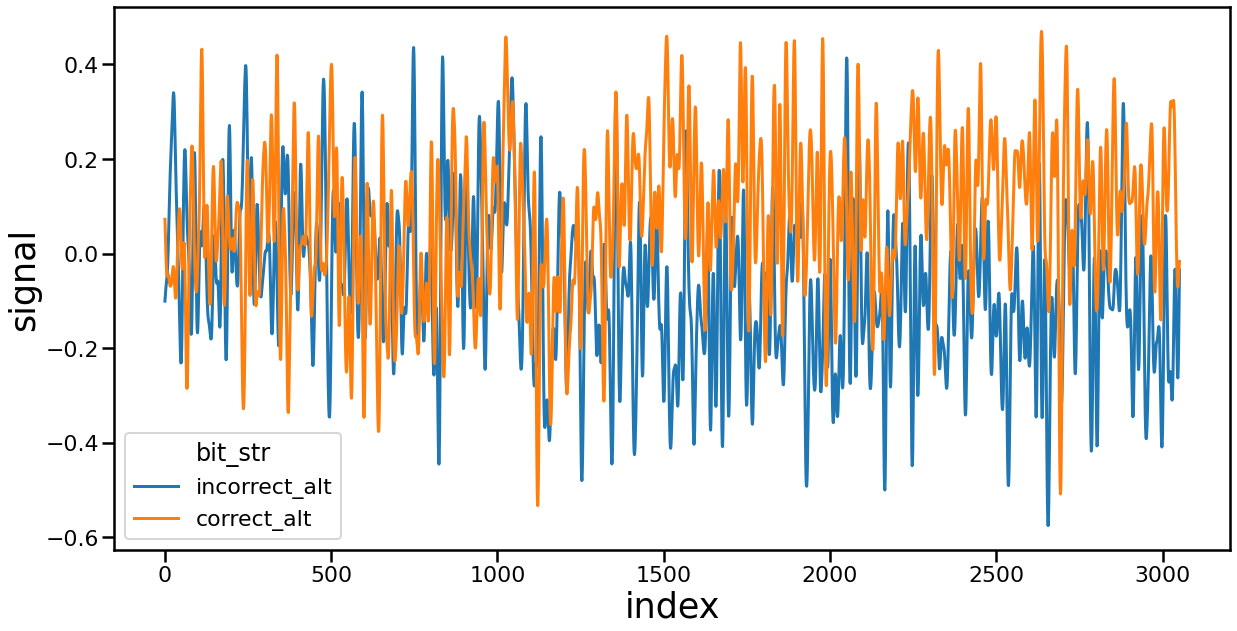

1343


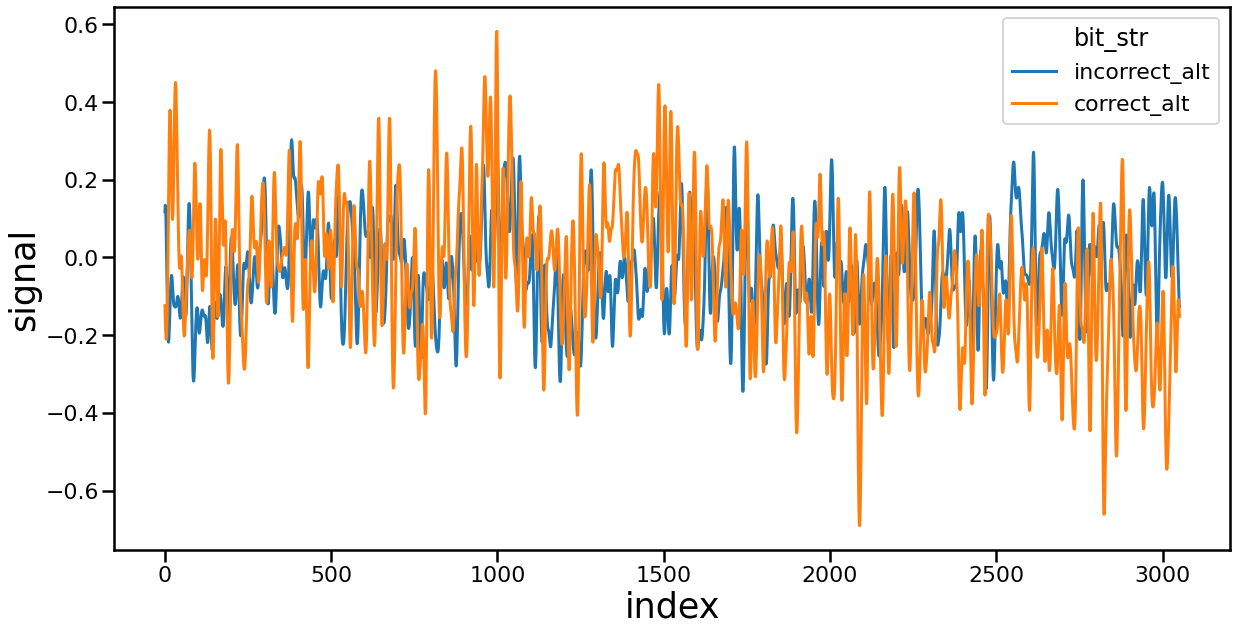

1283


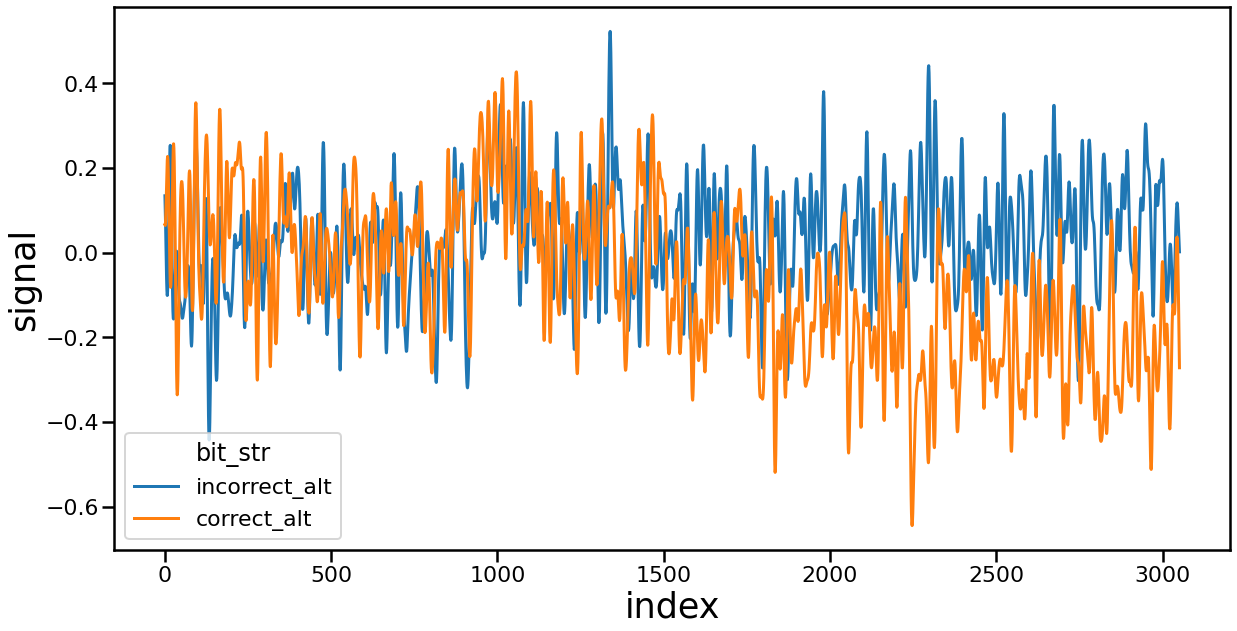

1338


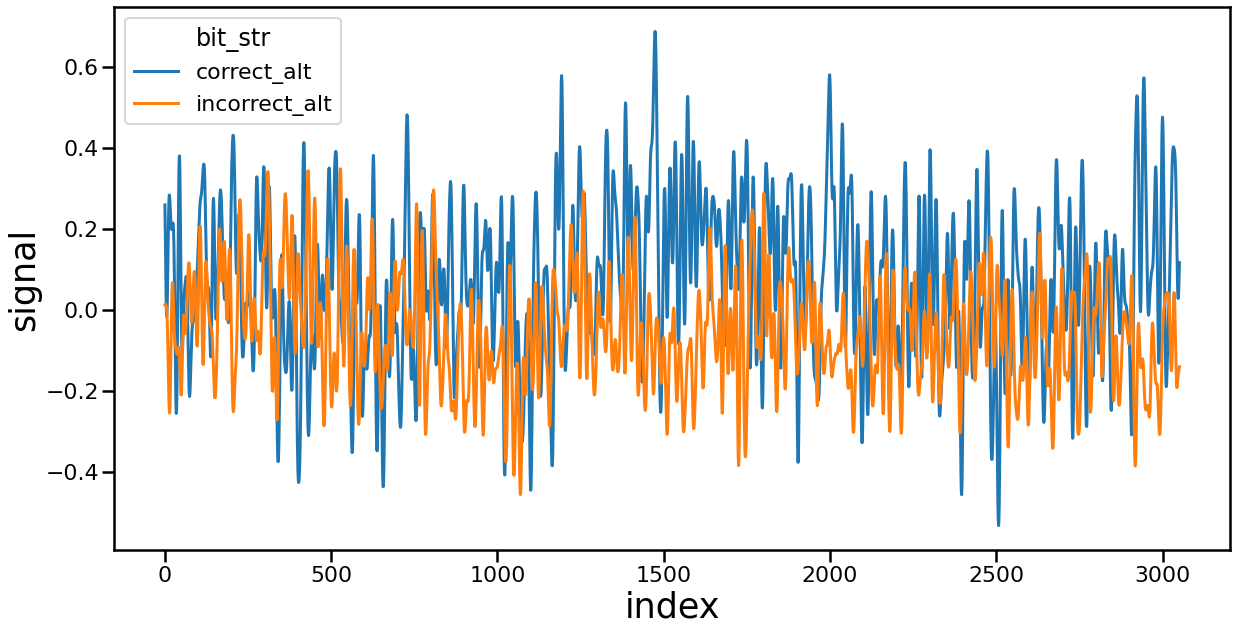

1341


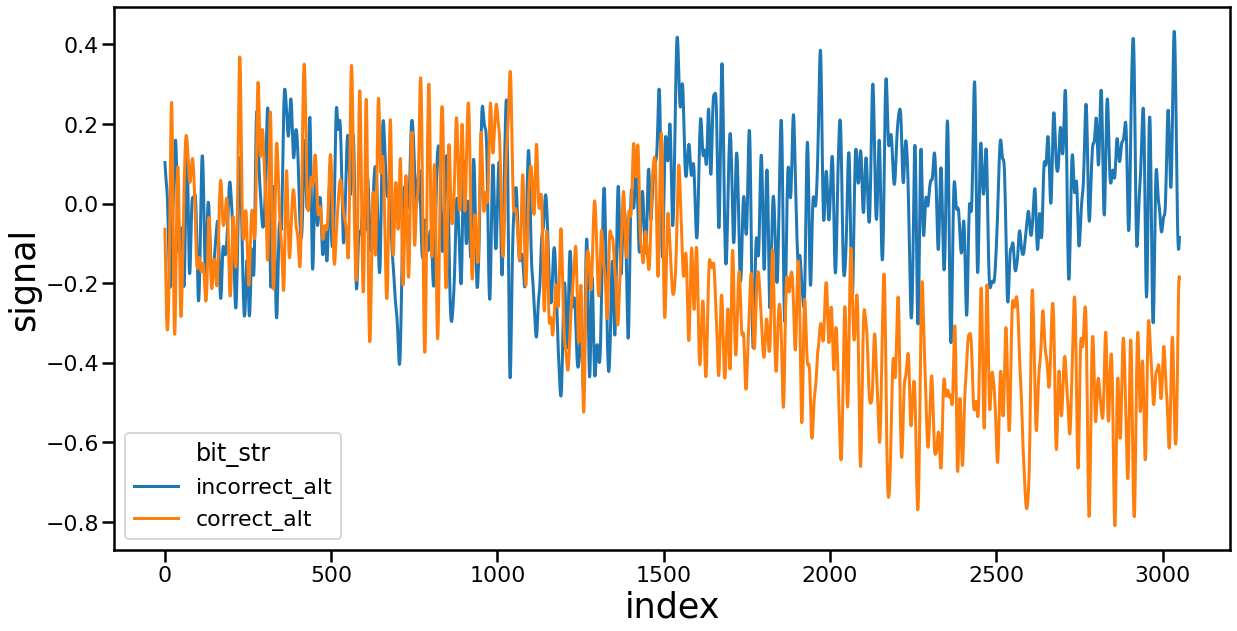

1687


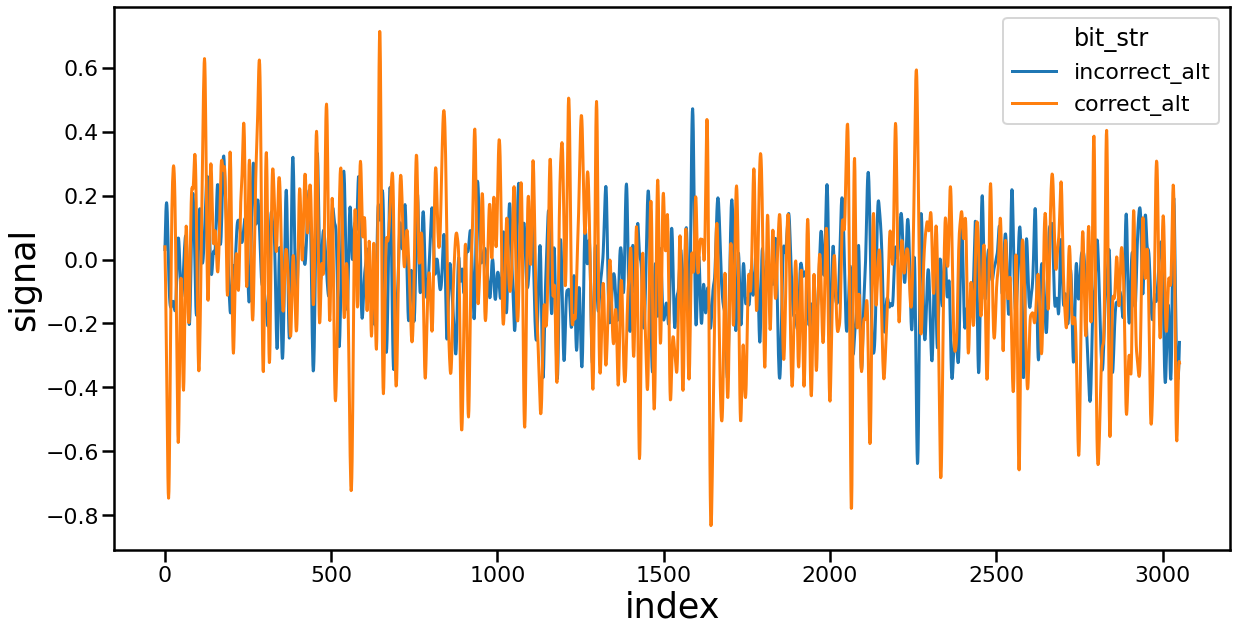

1686


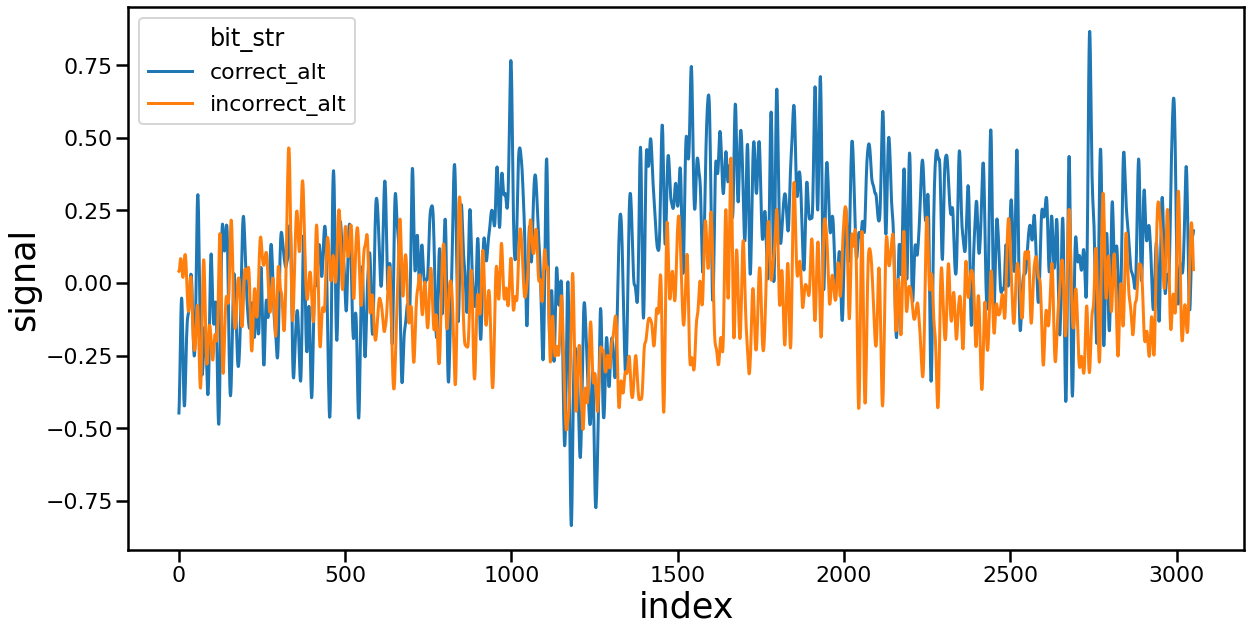

In [ ]:
d=data_final[data_final['sesnor']=='dopamine']
d=d[d['session']==1]
for animal in d['animal'].unique():
    print(animal)

    d1 = d[d['animal']==animal]
    bit_keep = ['correct_alt', 'incorrect_alt']#['correct_alt', 'incorrect_alt']
    d1 = d1[d1['bit_str'].isin(bit_keep)]
    #d = d[d['session']>2]

    plt.figure(figsize=(20,10))
    sns.lineplot(x='index', y='signal', data=d1, ci=None, hue='bit_str')
    plt.show()

In [ ]:
d = data_final.groupby(['bit_str', 'bit', 'session', 'animal', 'index'])['signal'].mean().reset_index()
#d = d[d['session']>4]
d = d[d['bit_str']=='reward_HE']
plt.figure(figsize=(10,5))

sns.relplot(
    data=d, x="index", y="signal",
    col="session", 
    kind="line",
    ci=None,
    col_wrap=3,
)

ValueError: ignored

<Figure size 720x360 with 0 Axes>

#### AUC and Max

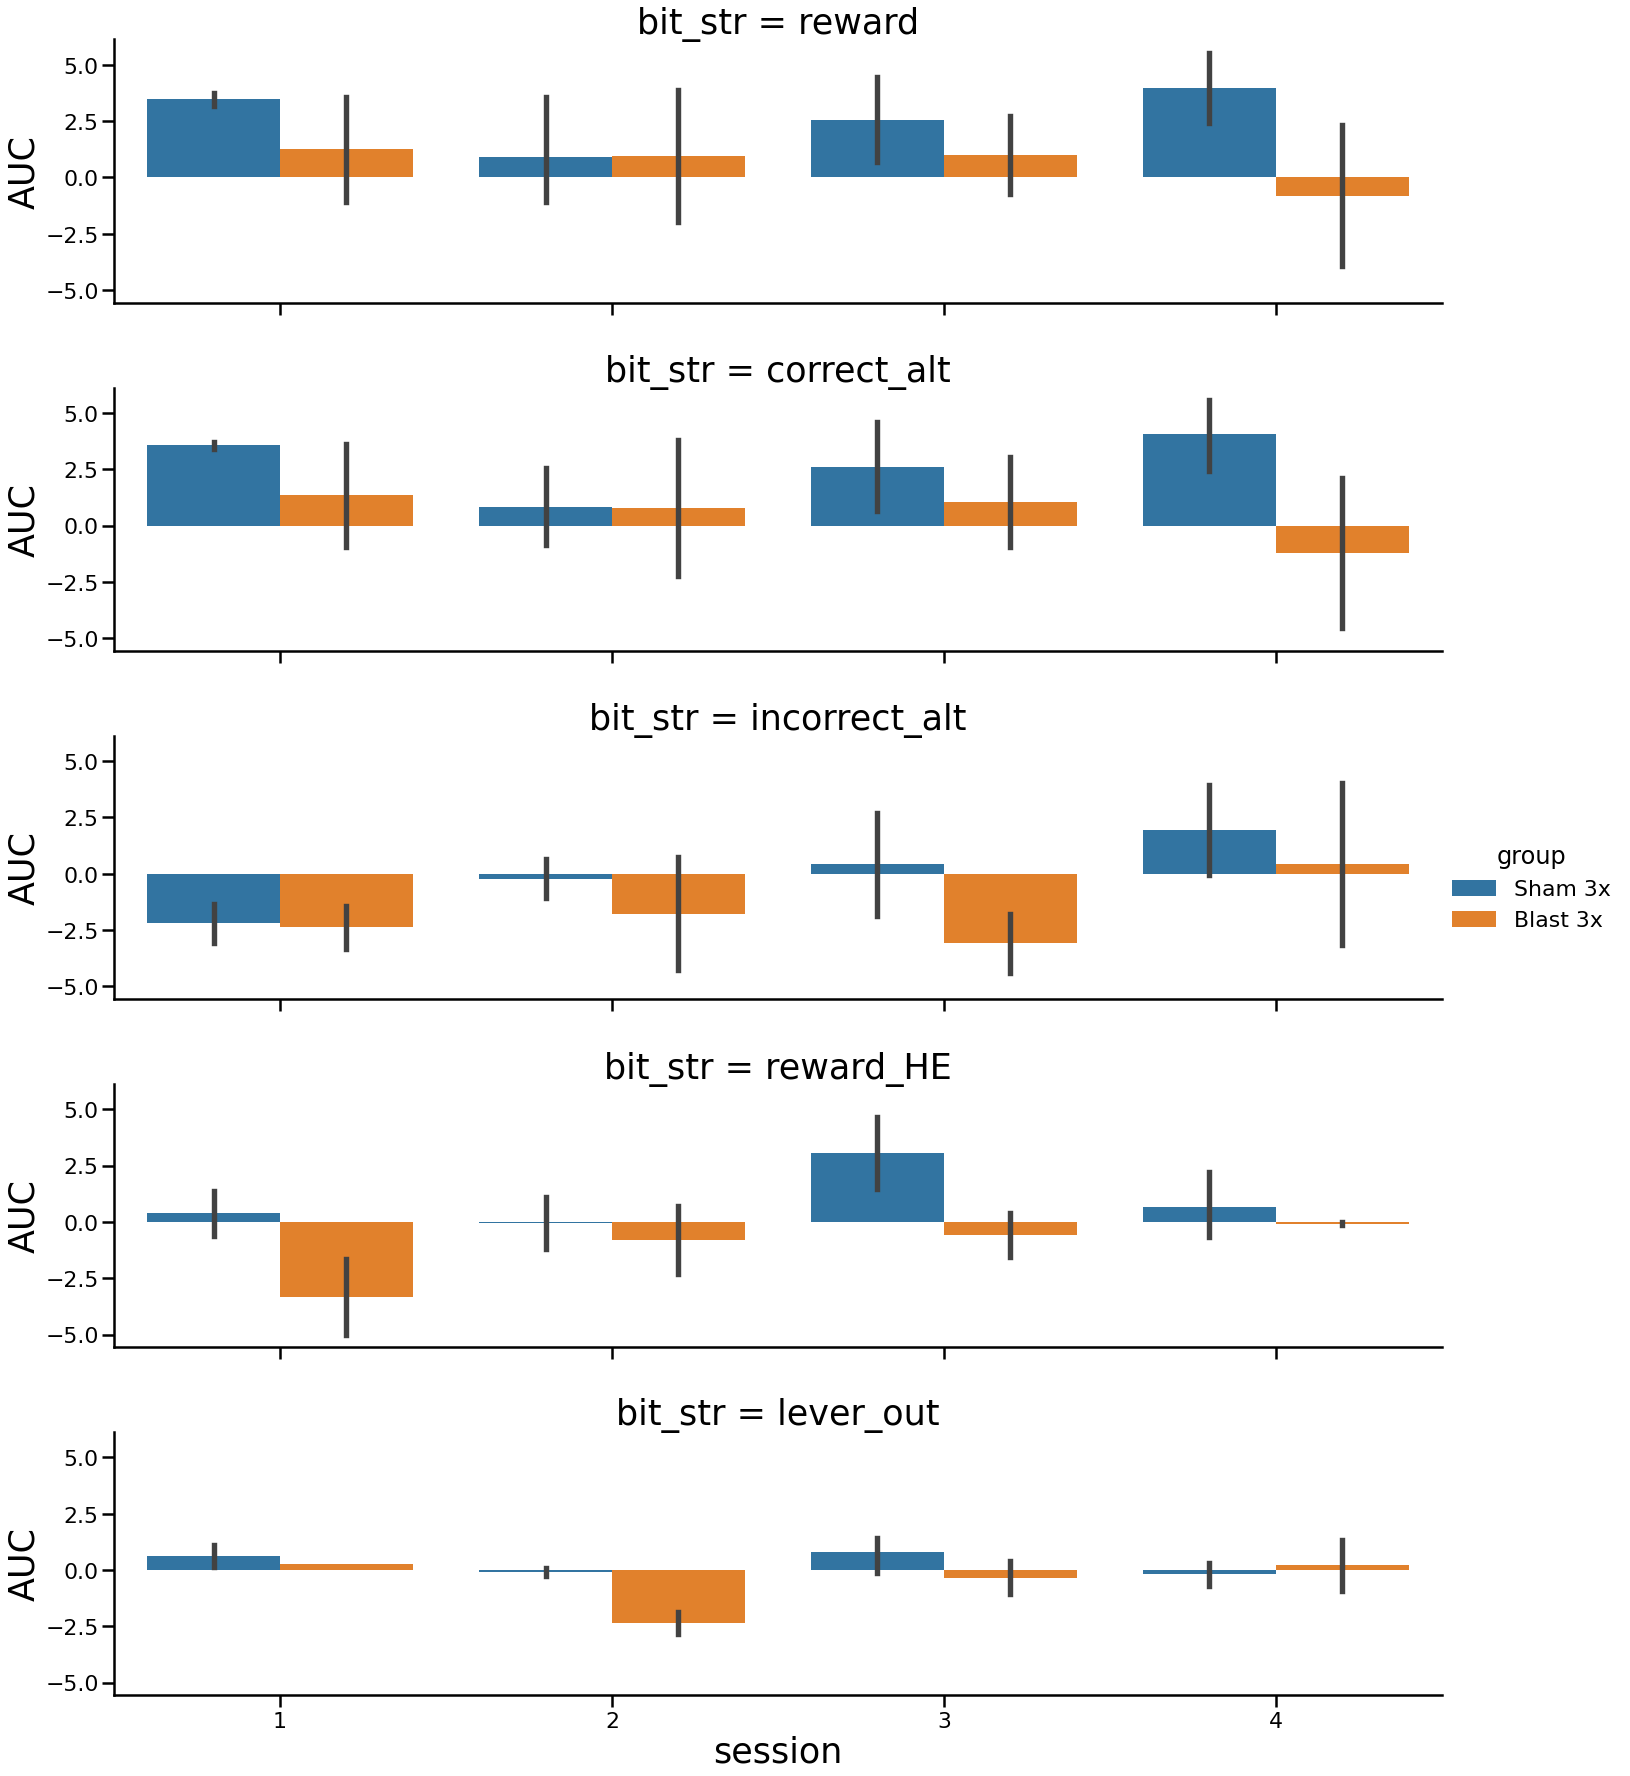

In [ ]:
#data_final_AUC =data_final_AUC[data_final_AUC['round']==2]
sns.catplot(x='session', y='AUC', data=data_final_AUC, ci=68, kind='bar', hue='group', height=5, aspect=4, col='bit_str', col_wrap=1)
plt.show()

In [ ]:
data_final_AUC.sort_values(['bit', 'session', 'group', 'animal', ]).to_csv('data_final_AUC.csv')

In [ ]:
data_final_AUC.to_csv('data_final_FR1.csv')

In [ ]:
#limit signals to 5 sec after lever press
start_time = 1000
end_time = 1500
data_final_bit = data_final[data_final['bit']=='2']
data_final_5after = data_final_bit[(data_final_bit['index']>=start_time) & (data_final['index']<end_time)]
data_final_5after_max = data_final_5after.groupby(['file_name', 'task', 'bit', 'animal', 'date', 'bit_str', 'group', 'round'])['signal'].max().reset_index()
data_final_5after_max.head()

In [ ]:
d=data_final[data_final['file_name']=='1154-210511-090932']
from numpy import trapz
area = trapz(d['index'],d['signal'])
area